Epoch 1, Train Loss: 4.4171, Val Loss: 4.0650, Val Accuracy: 0.2041
Epoch 2, Train Loss: 4.0626, Val Loss: 3.8487, Val Accuracy: 0.4592
Epoch 3, Train Loss: 3.8426, Val Loss: 3.6325, Val Accuracy: 0.5318
Epoch 4, Train Loss: 3.6259, Val Loss: 3.4887, Val Accuracy: 0.5520
Epoch 5, Train Loss: 3.4802, Val Loss: 3.3782, Val Accuracy: 0.5977
Epoch 6, Train Loss: 3.3693, Val Loss: 3.2962, Val Accuracy: 0.5547
Epoch 7, Train Loss: 3.2868, Val Loss: 3.2419, Val Accuracy: 0.5693
Epoch 8, Train Loss: 3.2311, Val Loss: 3.1676, Val Accuracy: 0.5503
Epoch 9, Train Loss: 3.1583, Val Loss: 3.1040, Val Accuracy: 0.5941
Epoch 10, Train Loss: 3.0925, Val Loss: 3.0233, Val Accuracy: 0.5986
Epoch 11, Train Loss: 3.0133, Val Loss: 2.9650, Val Accuracy: 0.6491
Epoch 12, Train Loss: 2.9534, Val Loss: 2.9145, Val Accuracy: 0.6320
Epoch 13, Train Loss: 2.9036, Val Loss: 2.8742, Val Accuracy: 0.6616
Epoch 14, Train Loss: 2.8626, Val Loss: 2.8403, Val Accuracy: 0.6445
Epoch 15, Train Loss: 2.8291, Val Loss: 2.8

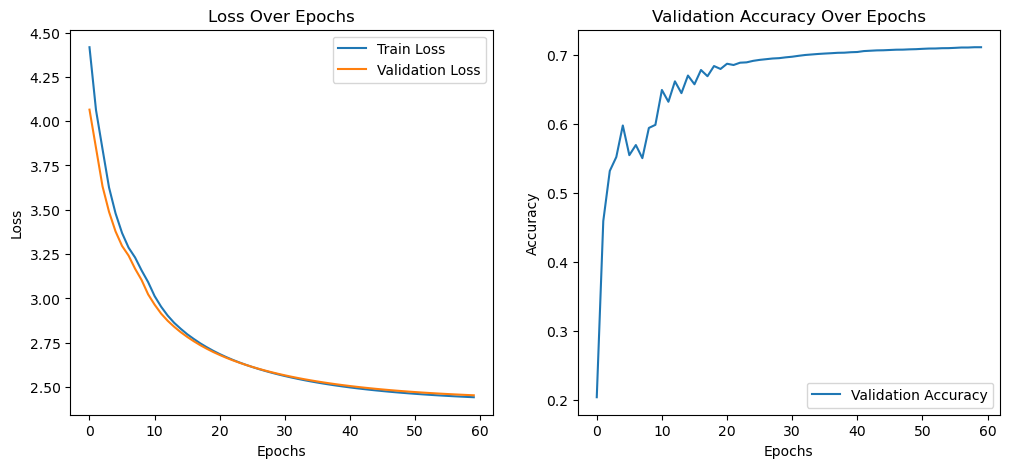

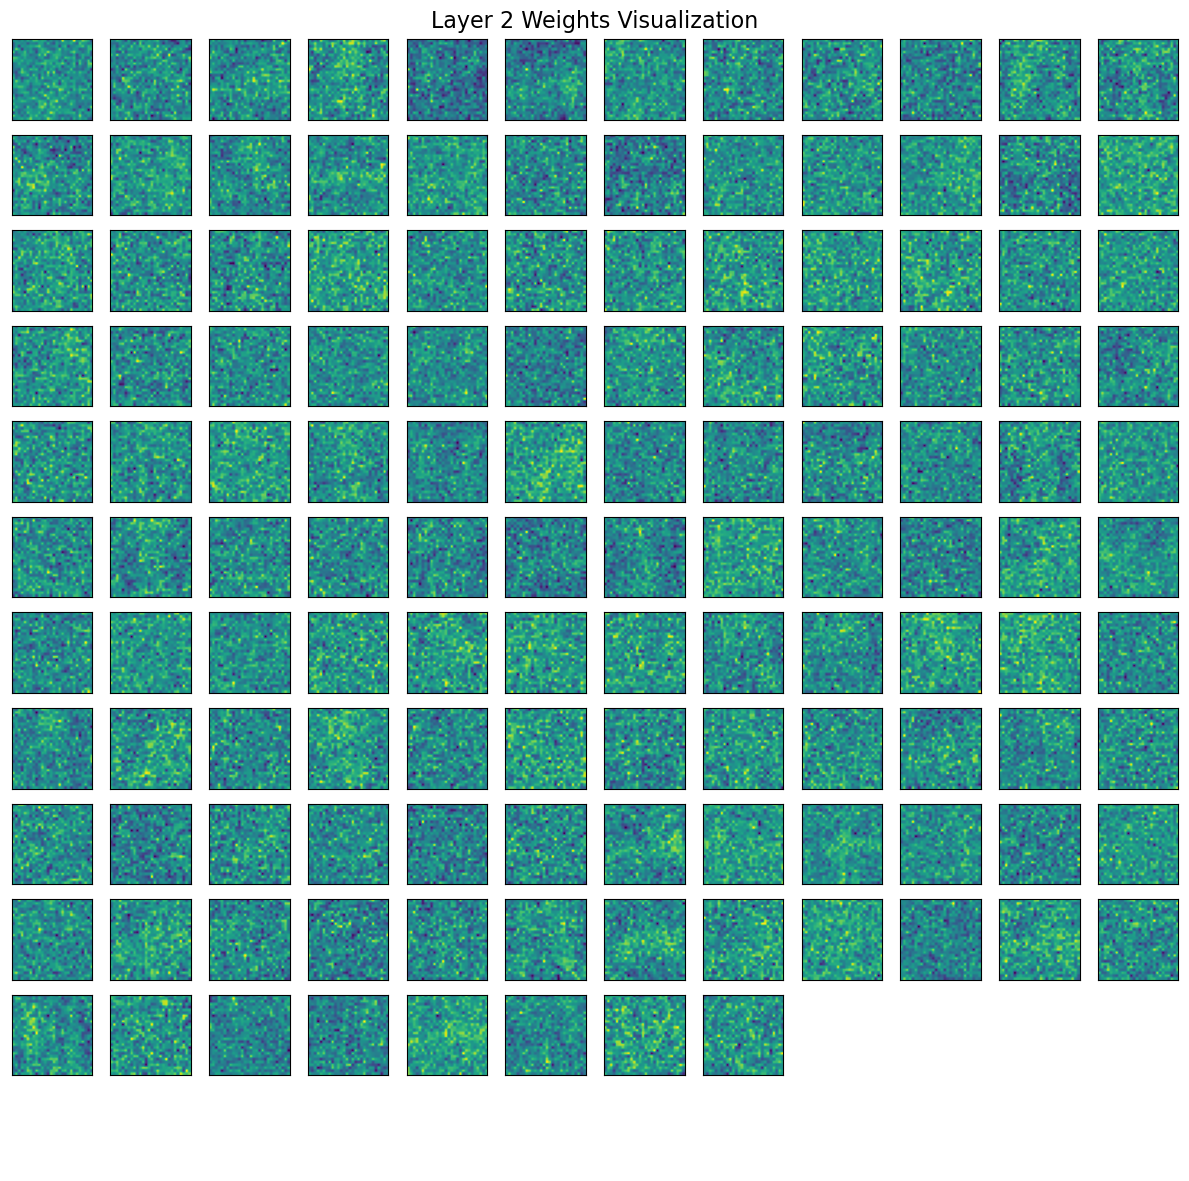

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist  # 导入Fashion MNIST数据集
from sklearn.model_selection import train_test_split  # 导入数据集切分函数

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, activation='relu', reg_lambda=0.01):
        self.params = {
            'W1': np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size),  # 初始化第一层权重
            'b1': np.zeros((1, hidden_size)),  # 初始化第一层偏置
            'W2': np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size),  # 初始化第二层权重
            'b2': np.zeros((1, output_size))  # 初始化第二层偏置
        }
        self.activation_str = activation  # 激活函数类型，默认为ReLU
        self.reg_lambda = reg_lambda  # 正则化系数

    def relu(self, x):
        return np.maximum(0, x)  # ReLU激活函数的实现

    def softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)  # Softmax激活函数的实现

    def forward(self, x):
        self.z1 = np.dot(x, self.params['W1']) + self.params['b1']  # 第一层前向传播
        self.a1 = self.relu(self.z1) if self.activation_str == 'relu' else np.tanh(self.z1)  # 第一层激活
        self.z2 = np.dot(self.a1, self.params['W2']) + self.params['b2']  # 第二层前向传播
        self.a2 = self.softmax(self.z2)  # 第二层激活（输出层）
        return self.a2

    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        log_likelihood = -np.log(y_pred[range(m), y_true])
        data_loss = np.sum(log_likelihood) / m
        reg_loss = 0.5 * self.reg_lambda * (np.sum(np.square(self.params['W1'])) + np.sum(np.square(self.params['W2'])))
        return data_loss + reg_loss  # 计算损失函数

    def backward(self, x, y_true):
        m = y_true.shape[0]
        y_pred = self.forward(x)

        delta2 = y_pred
        delta2[range(m), y_true] -= 1
        delta2 /= m

        dW2 = np.dot(self.a1.T, delta2) + self.reg_lambda * self.params['W2']
        db2 = np.sum(delta2, axis=0, keepdims=True)

        delta1 = np.dot(delta2, self.params['W2'].T)
        delta1[self.z1 <= 0] = 0  # ReLU激活函数的导数

        dW1 = np.dot(x.T, delta1) + self.reg_lambda * self.params['W1']
        db1 = np.sum(delta1, axis=0, keepdims=True)

        grads = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}
        return grads  # 反向传播计算梯度

    def update_params(self, grads, learning_rate):
        for key in self.params:
            self.params[key] -= learning_rate * grads[key]  # 更新参数

def load_data():
    (train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()  # 加载Fashion MNIST数据集
    train_X = train_X.reshape(train_X.shape[0], -1) / 255.0
    test_X = test_X.reshape(test_X.shape[0], -1) / 255.0
    train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)  # 划分训练集和验证集
    return train_X, train_y, val_X, val_y, test_X, test_y

def train(train_X, train_y, val_X, val_y, model, epochs, learning_rate, reg_lambda):
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }
    best_val_loss = float('inf')
    best_model_params = None

    for epoch in range(epochs):
        model.forward(train_X)
        train_loss = model.compute_loss(model.a2, train_y)
        grads = model.backward(train_X, train_y)
        model.update_params(grads, learning_rate)

        y_pred_val = model.forward(val_X)
        val_loss = model.compute_loss(y_pred_val, val_y)
        val_accuracy = np.mean(np.argmax(y_pred_val, axis=1) == val_y)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_params = {k: v.copy() for k, v in model.params.items()}

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        learning_rate *= 0.95  # 学习率衰减

    model.params = best_model_params
    return history, model

def evaluate(test_X, test_y, model):
    y_pred = model.forward(test_X)
    predictions = np.argmax(y_pred, axis=1)
    accuracy = np.mean(predictions == test_y)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show
    
def plot_weights(weights, layer_num):
    num_neurons = weights.shape[1]
    num_per_row = int(np.ceil(np.sqrt(num_neurons)))  # 计算每行应该有多少个图像，以尽可能接近正方形

    fig, axes = plt.subplots(num_per_row, num_per_row, figsize=(12, 12))
    fig.suptitle(f'Layer {layer_num} Weights Visualization', fontsize=16)
    
    # 归一化权重以改善可视化效果
    weight_min, weight_max = weights.min(), weights.max()
    weights = (weights - weight_min) / (weight_max - weight_min)

    for i, ax in enumerate(axes.flat):
        if i < num_neurons:
            img = weights[:, i].reshape(28, 28)  # 假设输入为28x28图像，适用于第一层
            ax.imshow(img, cmap='viridis')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    train_X, train_y, val_X, val_y, test_X, test_y = load_data()
    model = NeuralNetwork(input_size=784, hidden_size=128, output_size=10, reg_lambda=0.03)
    history, model = train(train_X, train_y, val_X, val_y, model, epochs=60, learning_rate=0.3, reg_lambda=0.03)
    evaluate(test_X, test_y, model)
    # 合并 model.params['W1'] 和 model.params['W2'] 成一个字典
    params_dict = {'W1': model.params['W1'], 'W2': model.params['W2']}
    # 保存参数字典到 .npy 文件
    np.save('input_size=784, hidden_size=128, output_size=10, reg_lambda=0.03, epochs=60, learning_rate=0.3.npy', params_dict)
    plot_metrics(history)
    plot_weights(model.params['W1'], layer_num=2)